In [1]:
import h5py 
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import glob

## From other EDA file

In [29]:
def compute_seq_id(disk_id, up_dw_id, sc_id, pm_id, or_id=0):
    """Compute the RICH PMT sequence ID"""
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return seq_id


def events_to_pandas(dfile):
    """Convert HDF5 events data to Pandas
    
    Parameters
    ----------
    dfile : HDF5 file
        The RICHAI HDF5 file to convert to pandas.
        
    Returns
    -------
    df : pd.DataFrame
        pandas DataFrame with Events data
    """
    
    df = pd.DataFrame()
    
    # event features
    df["run_id"] = dfile["Events"]["run_id"]
    df["burst_id"] = dfile["Events"]["burst_id"]
    df["event_id"] = dfile["Events"]["event_id"]
    df["track_id"] = dfile["Events"]["track_id"]
    df["track_momentum"] = dfile["Events"]["track_momentum"]
    df["chod_time"] = dfile["Events"]["chod_time"]
    df["ring_radius"] = dfile["Events"]["ring_radius"]
    df["ring_centre_pos_x"] = dfile["Events"]["ring_centre_pos"][:, 0]
    df["ring_centre_pos_y"] = dfile["Events"]["ring_centre_pos"][:, 1]
    df["ring_likelihood_pion"] = dfile["Events"]["ring_likelihood"][:, 0]
    df["ring_likelihood_muon"] = dfile["Events"]["ring_likelihood"][:, 1]
    df["ring_likelihood_positron"] = dfile["Events"]["ring_likelihood"][:, 2]
    
    # labels
    mu_off = dfile.attrs["muon_offset"]
    pi_off = dfile.attrs["pion_offset"]
    pos_off = dfile.attrs["positron_offset"]
    entries = dfile.attrs["entries"]
    
    labels = np.zeros(entries, dtype=np.int32)
    labels[mu_off:pi_off] = 0
    labels[pi_off:pos_off] = 1
    labels[pos_off:] = 2
    
    df["label"] = labels
    
    # hit mapping values
    df["first_hit"] = np.array(dfile["HitMapping"])[:-1]  # hit n
    df["last_hit"] = np.array(dfile["HitMapping"])[1:]    # hit n + 1
    df["total_hits"] = df["last_hit"] - df["first_hit"]
    
    return df


def get_class_samples(df, n, seed, momentum_bin=None, wide=None):
    """Sample n samples for each particle class from the events dataframe"""
    
    if momentum_bin and wide:
        df = df.query("wide_momentum_bin == @momentum_bin")
        
    if momentum_bin and not wide:
        df = df.query("narrow_momentum_bin == @momentum_bin")
        
    samples = pd.concat(
        [
            df[df["class"] == "muon"].sample(n=n, random_state=seed),
            df[df["class"] == "pion"].sample(n=n, random_state=seed),
            df[df["class"] == "positron"].sample(n=n, random_state=seed)        
        ]

    )
    
    return samples


def get_string_label(label):
    """Add string label to pandas df (to be used with map)"""
    if label == 0:
        return "muon"
    elif label == 1:
        return "pion"
    elif label == 2:
        return "positron"

## Redone and debugged

In [38]:
def get_hit_data(f, event):
    """Get the hit data for an event as a numpy array."""
    hit_data = []
    
    # get the raw hit data, hit time, and chod time
    hits = f["Hits"][
        f["HitMapping"][event]:f["HitMapping"][event+1]
    ]
    hit_times = hits["hit_time"]
    chod_time = f["Events"][event]["chod_time"]
    
    # compute (x, y) positions
    for hit in hits:
        idx = compute_seq_id(
            disk_id=hit["disk_id"],
            up_dw_id=hit["updowndisk_id"],
            sc_id=hit["supercell_id"],
            pm_id=hit["pmt_id"],
            or_id=0
        )

        hit_data.append(position_map[idx])

    # convert (x, y) positions to numpy array
    hit_data = np.array(hit_data)

    # create array of chod times
    chod_time = np.full((hit_data.shape[0], 1), chod_time)

    # join hits, hit times, and chod time
    hit_data = np.c_[hit_data, hit_times, chod_time]

    # create CHOD - time delta column
    hit_data = np.append(hit_data, hit_data[:, 4:] - hit_data[:, 3:4], axis=1)
    
    # final columns are x, y, mirror, hit time, chod time, delta
    return hit_data


def hit_data_to_pandas(hit_data):
    """Convert numpy array hits data to pandas format"""
    return pd.DataFrame(
        data=hit_data,
        columns=["x", "y", "mirror", "hit_time", "chod_time", "time_delta"]
    )


def realign_x_hits(x, mirror):
    """Realign x hits based on mirror"""
    if mirror == 0:
        return x - 146.8
    else:
        return x - 196.7
    
    
def realign_y_hits(y, mirror):
    """Realign y hits based on mirror"""
    if mirror == 0:
        return y - 19.8
    else:
        return y - 9.5
    
    
def plot_event(f, event, ax=None):
    # get the hit data for the event
    hit_data = get_hit_data(f, event)
    
    # convert data to pandas to make plotting code more readable
    hit_data_df = hit_data_to_pandas(hit_data)
    
    # realign x and y hits
    hit_data_df["x_realigned"] = hit_data_df.apply(
        lambda a: realign_x_hits(a.x, a.mirror), axis=1
    )
    hit_data_df["y_realigned"] = hit_data_df.apply(
        lambda a: realign_y_hits(a.y, a.mirror), axis=1
    )
     
    # get values for title
    radius = f["Events"][event]['ring_radius']
    momentum = f["Events"][event]['track_momentum']
    centre_x, centre_y = f["Events"][event]['ring_centre_pos']
    label = labels[event]
    
    # determine which mirror was hit
    if (hit_data[:, 2:3] == 0).all():
        mirror = "Jura"
    elif (hit_data[:, 2:3] == 1).all():
        mirror = "Saleve"
    else:
        mirror = "Both"
    
    if not ax:
        fig = plt.figure(figsize=(7, 7))
        ax = fig.subplots()
    
    # plot realigned hits
    im = ax.scatter(
        x=hit_data_df["x_realigned"],
        y=hit_data_df["y_realigned"],
#         c=np.power(hit_data_df["time_delta"], 2),
        c=np.abs(hit_data_df["time_delta"]),
        cmap="cividis"
    )
    
    if label == 0:
        color = "#1170aa"
    elif label == 1:
        color = "#fc7d0b"
    elif label == 2:
        color = "#a3acb9"
    
    # plot the circle
    ax.add_artist(
        plt.Circle((centre_x, centre_y), radius, fill=False,color=color)
    )
    
    # add a colourbar
    cbar = plt.colorbar(im, shrink=0.5, ax=ax)
    
    # other customizations
    ax.set_title(
        f"""Event: {event}, Mirror:{mirror}
        Radius: {radius:.2f}, Momentum: {momentum:.2f}
        Centre ({centre_x:.2f}, {centre_y:.2f})
        Label: {label}""" 
    )
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_aspect('equal')
    ax.set_xlim(-500,500)
    ax.set_ylim(-500,500)
    
    return ax

In [39]:
# read in the data
data_folder = "/data/bvelghe/capstone2022/"
data_set = "A/"
file_path = "Run008548.EOSlist.CTRL.p.v2.0.4-01_f.v2.0.4-01.h5"
f = h5py.File(os.path.join(data_folder, data_set, file_path))

# create labels
mu_off = f.attrs["muon_offset"]
pi_off = f.attrs["pion_offset"]
pos_off = f.attrs["positron_offset"]
entries = f.attrs["entries"]
labels = np.zeros(entries, dtype=np.int32)
labels[mu_off:pi_off] = 0
labels[pi_off:pos_off] = 1
labels[pos_off:] = 2

# position map
position_map = np.load("/home/nico/RICHPID/tools/rich_pmt_positions.npy")
position_map.shape

(1952, 3)

In [40]:
# this is an example pandas df that is used for plotting
hit_data = get_hit_data(f, event=1)
hit_data_df = hit_data_to_pandas(hit_data)
hit_data_df["x_realigned"] = hit_data_df.apply(
    lambda a: realign_x_hits(a.x, a.mirror), axis=1
)
hit_data_df["y_realigned"] = hit_data_df.apply(
    lambda a: realign_y_hits(a.y, a.mirror), axis=1
)

hit_data_df.head()

,x,y,mirror,hit_time,chod_time,time_delta,x_realigned,y_realigned
0,-27.0,-31.180000,0.0,6.109514,6.220097,0.110583,-173.8,-50.980000
1,-18.0,-77.940002,0.0,6.063055,6.220097,0.157043,-164.8,-97.740002
2,-36.0,-15.590000,0.0,6.271838,6.220097,-0.051741,-182.8,-35.390000
3,135.0,-187.059998,0.0,6.225278,6.220097,-0.005181,-11.8,-206.859998
4,216.0,171.470001,0.0,6.167874,6.220097,0.052223,69.2,151.670001


- 90 plots are below
- It looks like the ring now either perfectly lines up, or is to the left of where it should be
- The blue points are the ones that are close to CHOD time
- The yellow points are the ones that are far from the CHOD time

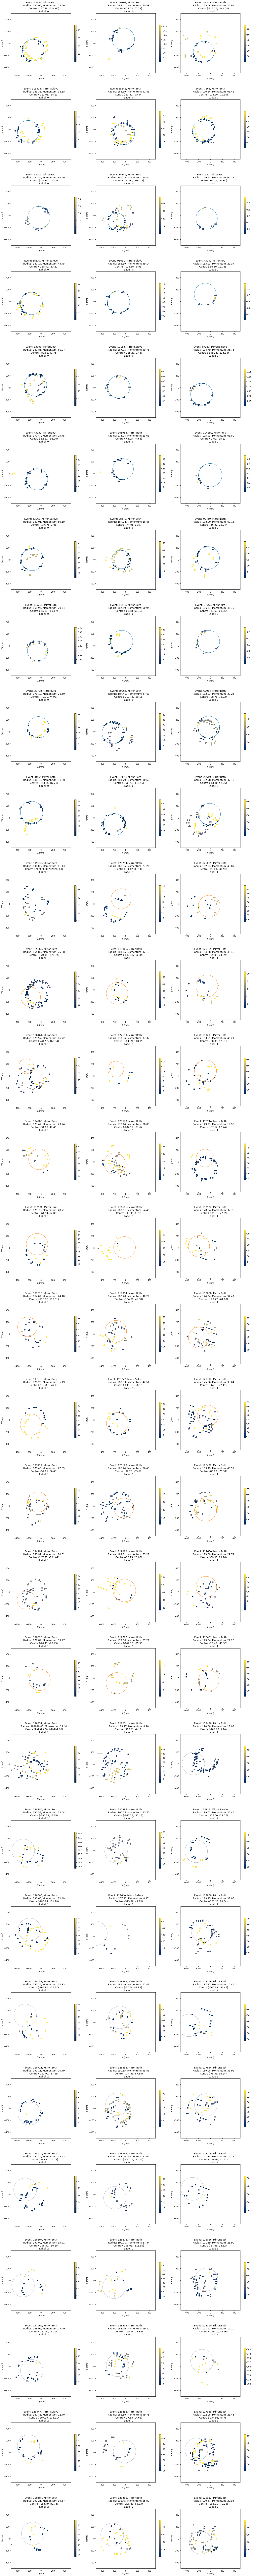

In [41]:
np.random.seed(42)

# plot 30 examples
n = 30
# samples = np.random.randint(0, len(f["Events"]), size=n)

df = events_to_pandas(f)
df["class"] = df["label"].apply(get_string_label)
samples = get_class_samples(df, n, 42)

cols = 3
rows = (n*3) // cols
rows += (n*3) % cols

fig, ax = plt.subplots(rows, cols, figsize=(cols * 6, 6 * rows))
ax=ax.flatten()

for i, event in enumerate(samples.index):
    plot_event(f, event, ax[i]);

plt.tight_layout()
plt.show()